# Import các thư viện cần thiết

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

import requests
from bs4 import BeautifulSoup
import urllib.request
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import time

from urllib import parse
from urllib import robotparser
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.neural_network import MLPRegressor,MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import set_config
set_config(display='diagram')

# Thu thập dữ liệu
 - Nhóm thực hiện việc thu thập dữ liệu từ 3 trang web bán điện thoại tại Việt Nam, bao gồm: https://didongthongminh.vn/dien-thoai,  https://www.nguyenkim.com/dien-thoai-di-dong,  https://www.thegioididong.com/dtdd .
 Viêc thu thập dẽ liệu từ 3 trang web này được check robotparser như sau: 

### Check robotparser

In [2]:
urls = ['https://www.nguyenkim.com/dien-thoai-di-dong',
       'https://www.nguyenkim.com/dien-thoai-di-dong',
       'https://www.thegioididong.com/dtdd']
for url in urls:
    URL_BASE = url
    parser = robotparser.RobotFileParser()
    parser.set_url(parse.urljoin(URL_BASE, 'robots.txt'))
    parser.read()
    print(url,'check = ', parser.can_fetch('*', url))

https://www.nguyenkim.com/dien-thoai-di-dong check =  True
https://www.nguyenkim.com/dien-thoai-di-dong check =  True
https://www.thegioididong.com/dtdd check =  True


###  Thu thập dữ liệu từ trang web https://didongthongminh.vn/dien-thoai
 - Thực hiện bằng phương pháp parser html

In [3]:
# Đây là các thuộc tính cơ bản của một điện thoại.
# Nhóm sẽ tiến hành thu thập các thông tin bao gồm: tên, ram, rom, dung lượng pin, màn hình, cpu, camera chính
# và camera selfie và giá thành.

Name = []
Ram = []
Rom =[]
Pin = []
Screen = []
Cpu = []
Main_Camera = []
Selfie_Camera = []
Price =[]
i = 1
while True:
    url = f'https://didongthongminh.vn/dien-thoai/page/{i}'
    i +=1
    html_text = requests.get(url).text
    tree = BeautifulSoup(html_text, "html.parser")
    phone_list = tree.find_all('div',{'class':'dst_hproduct_hidden'})
    if len(phone_list) == 0:
        break
    for phone in phone_list:
        # Tên điện thoại.
        try:
            name = phone.find('a',{'class':'dst_hproduct_title'}).text
        except:
            name = ''
        Name.append(name)
        configuration = phone.find_all('span',{'class':'dst_cauhinh'})
        # Màn hình 
        try:
            screen = configuration[0].text[configuration[0].text.find(":")+1:]
        except:
            screen = ''
        Screen.append(screen)
        # CPU
        try:
            cpu = configuration[1].text[configuration[1].text.find("CPU:")+len("CPU: "):]
        except:
            cpu = ''
        Cpu.append(cpu)
        # Camera
        try:
            main_c = configuration[3].text[configuration[3].text.find("Camera:")+len("Camera:")+1:configuration[3].text.find("Selfie:")-2]
            selfie_c = configuration[3].text[configuration[3].text.find("Selfie:")+len("Selfie:")+1:]
        except:
            main_c =''
            selfie_c =''
        Main_Camera.append(main_c)
        Selfie_Camera.append(selfie_c)
        # Ram
        try:
            ram = configuration[2].text[len('Ram:'):configuration[2].text.find(',')]
        except:
            ram = ''
        Ram.append(ram)
        # Rom
        try:
            rom = configuration[2].text[configuration[2].text.rfind(':')+1:]
        except:
            rom = ''
        Rom.append(rom)
        # dung lượng Pin
        try:
            pin = configuration[4].text[len("Pin: "):]
        except:
            pin = ''
        Pin.append(pin)
        # giá điện thoại.
        try:
            price = phone.find('div',{'class':"dst_hproduct_price"}).text
        except:
            price = ''
        Price.append(price)

### Thu thập dữ liệu từ trang web: https://www.nguyenkim.com/dien-thoai-di-dong

In [4]:
i = 1
while True:
    url = f'https://www.nguyenkim.com/dien-thoai-di-dong/page-{i}/'
    i +=1
    html_text = requests.get(url).text
    tree = BeautifulSoup(html_text, "html.parser")
    urls = tree.find_all('a', {'class': 'nk-link-product'})
    if len(urls) == 0:
        break
    for u in urls:
        phone_html_text = requests.get(u['href']).text
        phone_tree = BeautifulSoup(phone_html_text, "html.parser")
        
        # Tên điện thoại
        try:
            name = phone_tree.find('h1',{'class':'product_info_name'}).text.replace("Điện thoại ","")
        except:
            name = ''
        Name.append(name)
        
        configurations = phone_tree.find('tbody',{'class':'popup'}).find_all('tr') # thông số kỹ thuật.
        conf = []
        for _conf in configurations:
            s = _conf.text.split(":")
            conf.append((s[0],s[1]))
        conf = dict(conf)
        
        # Màn hình
        try:
            screen = conf["Kích thước màn hình"]
        except:
            screen =''
            
        Screen.append(screen)
            
        # Cpu
        try:
            cpu = conf["Chipset"]
        except:
            cpu = ''
        Cpu.append(cpu)
        
        # Camera
        try:
            selfie_c = conf["Camera trước"]
        except:
            selfie_c =''
        Selfie_Camera.append(selfie_c)
                             
        try:
            main_c = conf["Camera sau"]
        except:
            main_c =''
        Main_Camera.append(main_c)
        
        # Ram
        try:
            ram = conf["RAM"]
        except:
            ram =''
        Ram.append(ram)
        
        #Rom
        try:
            rom = conf["Bộ nhớ trong"]
        except:
            rom = ''
        Rom.append(ram)
        
        # dung lượng Pin
        try:
            pin = conf["Dung lượng Pin"]
        except:
            pin =''
        Pin.append(pin)
        
        # giá điện thoại
        try:
            price = phone_tree.find('div',{'class':'product_info_price_value-final'}).text
        except:
            price = ''
        Price.append(price)


### Thu thập dữ liệu từ web: https://www.thegioididong.com/dtdd
- Việc tải nhiều trang cho các điện thoại khác nhau nên phải tương tác với trang web, do đó nhóm đã sử dụng phương pháp webdriver để tải các trang và thu thập dữ liệu.

In [5]:
# Mở Chrome
browser = webdriver.Chrome(executable_path='./chromedriver.exe')
# Mở trang chủ của thế giới di động
browser.get('https://www.thegioididong.com/dtdd')
while True:
    time.sleep(1)
    try:
        browser.find_element_by_css_selector('a.viewmore').click()
    except:
        break
        
html_text = browser.page_source
browser.quit()
tree = BeautifulSoup(html_text, 'html.parser')
phones = tree.find_all('li',{'class':'item'})
for phone in phones:
    url = phone.find('a')['href']
    url='https://www.thegioididong.com'+url
    phone_html_text = requests.get(url).text
    tree = BeautifulSoup(phone_html_text, 'html.parser')
    #tên
    try:
        name=tree.find('div',{'class':'rowtop'}).h1.text.replace('Điện thoại ','')
    except:
        name=''
    parameter=tree.find('ul',{'class':'parameter'})
    #màn hình
    try:
        screen=parameter.find('li',{'class':'g6459_79_77'}).div.text
    except:
        screen=''
    #cpu
    try:
        cpu=parameter.find('li',{'class':'g6059'}).div.text
    except:
        cpu=''
    #caera trước
    try:
        main_camera=parameter.find('li',{'class':'g27'}).div.text
    except:
        main_camera=''
    #camera sau
    try:
        selfie_camera=parameter.find('li',{'class':'g29'}).div.text
    except:
        selfie_camera=''
    #rom
    try:
        rom=parameter.find('li',{'class':'g49'}).div.text
    except:
        rom=''
    #ram
    try:
        ram=parameter.find('li',{'class':'g50'}).div.text
    except:
        ram=''
    #pin
    try:
        pin=parameter.find('li',{'class':'g84_10882'}).div.text
    except:
        pin=''
    #giá
    try:
        price=tree.find('div',{'class':'area_price'}).strong.text
    except:
        price=''
    Name.append(name)
    Screen.append(screen)
    Cpu.append(cpu)
    Main_Camera.append(main_camera)
    Selfie_Camera.append(selfie_camera)
    Rom.append(rom)
    Ram.append(ram)
    Pin.append(pin)
    Price.append(price)

In [6]:
df = pd.DataFrame({'Name' : pd.Series(Name),
                   'Screen' : pd.Series(Screen),
                   'Cpu' : pd.Series(Cpu),
                   'MainCamera' : pd.Series(Main_Camera),
                   'SelfieCamera' : pd.Series(Selfie_Camera),
                   'Rom' : pd.Series(Rom),
                   'Ram' : pd.Series(Ram),
                   'Pin' : pd.Series(Pin),
                   'Price': pd.Series(Price)})

- Ghi thông tin vào file data_colection.csv để dễ xử lý về sau.

In [7]:
export_csv = df.to_csv ('phone_data.csv', index = None, header=True)

# Khám phá dữ liệu và nhận định câu hỏi

### Khám phá dữ liệu:

In [57]:
df_pre = pd.read_csv('data_colection.csv')

In [58]:
# Xem dữ liệu:
df_pre

,Name,Screen,Cpu,MainCamera,SelfieCamera,Rom,Ram,Pin,Price
0,Xiaomi POCO M3 - Chính hãng,"IPS LCD, 6.53"", Full HD+",Snapdragon 662 8 nhân,"Chính 48 MP & Phụ 2 MP, 2 MP",8MP,128/64 GB,4GB,6000mAh,3.490.000 Đ
1,Oppo Reno5 8GB/128GB chính hãng,"6,43 inch, OLED",Qualcomm SM7125 Snapdragon 720G (8 nm),"Chính 64 MP & Phụ 8 MP, 2 MP, 2 MP",44MP,128 GB,8 GB,4.310 mAh + Sạc nhanh 50W,7.990.000 Đ
2,Redmi Note 9 Pro 5G 6Gb/128Gb,,Octa-core (2x2.2 GHz Kryo 570 & 6x1.8 GHz Kryo...,Chính 108MP+8MP+2MP+2MP,16MP,128 GB,6GB,Li-Po 4820 mAh,6.390.000 Đ
3,iPhone SE Cũ 16Gb Nguyên Bản,"IPS LCD, 4.0"", DVGA",Apple A9,12 MP,1.2 MP,16 GB,2 GB,Li-Po 1624 mAh,2.190.000 Đ
4,Oppo Reno5Pro 8GB/128GB Hàng chính hãng,"OLED, 6.55"", Full HD+",8 nhân,"Chính 64 MP & Phụ 8 MP, 2 MP, 2 MP",32MP,256GB,8 GB,Có sạc ngược,Liên hệ
...,...,...,...,...,...,...,...,...,...
1823,Mobell C310,NaN,NaN,0.8 MP,NaN,NaN,NaN,NaN,200.000₫
1824,Mobell M229 (2019),NaN,NaN,0.8 MP,NaN,NaN,NaN,NaN,190.000₫
1825,Masstel IZI 120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,190.000₫
1826,Itel Value 100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,170.000₫


In [59]:
# kiểm tra có trùng lặp dữ liệu không?
df_pre.duplicated().sum()

111

#### Nhận xét dữ liệu: 
- Xóa các dòng dữ liệu bị trùng lắp.
- Quan sát những dòng cuối nhận thấy có quá nhiều thuộc tính thiếu giá trị. Do đó nên xóa các dòng này.
- Giá điện thoại có các gía trị thiếu và các giá trị 'Liên hệ'. Vì Giá điện thoại và thuộc tính phân lớp nên phải xóa các dòng này.
- Các thuộc tính camera, pin, ram, rom có thể chuyển về dạng số.
- Thuộc tính Cpu có quá nhiều loại, rất khó khăn trong việc nhận dạng để tách.

#### Đặt câu hỏi:
- Câu hỏi: Dự đoán mức giá của điện thoại thông qua các thông số kỹ thuật của máy. Các mức giá do nhóm tìm hiểu trên thị trường như sau:
    + Điện thoại gía rẽ: Giá dưới 6 triệu vnd.
    + Điện thoại tầm trung: Giá dao động từ 6 đến 10 triệu vnd.
    + Điện thoại cao cấp: Gía dao động từ 10 đến 18 triệu vnd.
    + Điện thoại cao cấp( flagship): Giá trên 18 triệu vnd.

 #### Quan sát các thuộc tính: 
 - Ở thuôc tính Name có thể tách ra hãng sản xuất, do thực tế có thể thấy rằng, mỗi hãng khác nhau sẽ có giá bán khác nhau.
 - Các thuộc tính Screen, Main Camera, Selfie Camera, Ram, Rom và Pin có thể tách lấy các giá trị dạng số bằng với :
     + Screen: lấy kích thước màn hình( đơn vị inchs).
     + Main Camera, Selfie Camera: lấy giá trị độ phân giải của camera chính.( đối với giá trị có nhiều giá trị, ví dụ:Chính 48 MP & Phụ 8 MP, 2 MP, 2 MP, thì chỉ lấy giá trị camera chính.
     + Đối với Ram và Rom xử lí chuỗi bình thường.
 - Thuộc tính CPU có thể tách ra loại chip: ví dụ: Qualcomm Snapdragon, MediaTek, Exynos, ... Nhưng trên thị trường có quá nhiều phiên bản khác nhau của chip nên sẽ bỏ qua cột dữ liệu này :((

### Tiền xử lý cơ bản dữ liệu: Như đã đề cập ở trên.

In [60]:
# Xóa dòng dữ liệu thiếu.
for idx in df_pre.index:
    if df_pre.loc[idx].isna().sum() >= 5:
        df_pre.drop(idx, inplace=True)
        
# Xóa dòng dữ liệu với các giá trị ở thuộc tính giá là 'Liên hệ' hoặc bị thiếu.
df_pre.drop(df_pre[df_pre.Price == 'Liên hệ'].index, inplace=True)

df_pre.drop(df_pre[df_pre.Price.isna() == True].index, inplace=True)

In [61]:
df_pre

,Name,Screen,Cpu,MainCamera,SelfieCamera,Rom,Ram,Pin,Price
0,Xiaomi POCO M3 - Chính hãng,"IPS LCD, 6.53"", Full HD+",Snapdragon 662 8 nhân,"Chính 48 MP & Phụ 2 MP, 2 MP",8MP,128/64 GB,4GB,6000mAh,3.490.000 Đ
1,Oppo Reno5 8GB/128GB chính hãng,"6,43 inch, OLED",Qualcomm SM7125 Snapdragon 720G (8 nm),"Chính 64 MP & Phụ 8 MP, 2 MP, 2 MP",44MP,128 GB,8 GB,4.310 mAh + Sạc nhanh 50W,7.990.000 Đ
2,Redmi Note 9 Pro 5G 6Gb/128Gb,,Octa-core (2x2.2 GHz Kryo 570 & 6x1.8 GHz Kryo...,Chính 108MP+8MP+2MP+2MP,16MP,128 GB,6GB,Li-Po 4820 mAh,6.390.000 Đ
3,iPhone SE Cũ 16Gb Nguyên Bản,"IPS LCD, 4.0"", DVGA",Apple A9,12 MP,1.2 MP,16 GB,2 GB,Li-Po 1624 mAh,2.190.000 Đ
5,Oppo A15 3GB/32GB Hàng chính hãng,"IPS LCD, 6.52"", HD+",MediaTek Helio P35 8 nhân,"Chính 13 MP & Phụ 2 MP, 2 MP",5MP,32 GB,3 GB,Li-Po 4230 mAh,3.290.000 Đ
...,...,...,...,...,...,...,...,...,...
1786,Masstel HAPI 10 Fami,"IPS LCD, 5"", HD",MediaTek MT6739 4 nhân,5 MP,5 MP,16 GB,2 GB,2000 mAh,1.070.000₫
1788,Itel Alpha Lite,"TFT LCD, 5"", FWVGA",Spreadtrum SC7731E 4 nhân,5 MP,2 MP,8 GB,1 GB,2050 mAh,990.000₫
1789,Mobell P41,"IPS LCD, 5.5"", FWVGA+",MediaTek MT6580A 4 nhân,5 MP,2 MP,8 GB,1 GB,3500 mAh,890.000₫
1790,Masstel X5 Fami,"IPS LCD, 5.45"", HD+",Spreadtrum SC7731E 4 nhân,8 MP,5 MP,8 GB,1 GB,3200 mAh,890.000₫


- Chuyển dữ liệu thuộc tính Price sang dạng dùng để phân lớp.

In [62]:
for idx in df_pre.Price.index:
    price = int(df_pre.Price[idx].replace('.','').replace('Đ','').replace('đ','').replace('₫','').replace(' ',''))
    if price < 6000000:
        df_pre['Price'][idx] = 1
    elif price <10000000:
        df_pre['Price'][idx] = 2
    elif price < 18000000:
        df_pre['Price'][idx] = 3
    else:
        df_pre['Price'][idx] = 4

In [63]:
df_pre

,Name,Screen,Cpu,MainCamera,SelfieCamera,Rom,Ram,Pin,Price
0,Xiaomi POCO M3 - Chính hãng,"IPS LCD, 6.53"", Full HD+",Snapdragon 662 8 nhân,"Chính 48 MP & Phụ 2 MP, 2 MP",8MP,128/64 GB,4GB,6000mAh,1
1,Oppo Reno5 8GB/128GB chính hãng,"6,43 inch, OLED",Qualcomm SM7125 Snapdragon 720G (8 nm),"Chính 64 MP & Phụ 8 MP, 2 MP, 2 MP",44MP,128 GB,8 GB,4.310 mAh + Sạc nhanh 50W,2
2,Redmi Note 9 Pro 5G 6Gb/128Gb,,Octa-core (2x2.2 GHz Kryo 570 & 6x1.8 GHz Kryo...,Chính 108MP+8MP+2MP+2MP,16MP,128 GB,6GB,Li-Po 4820 mAh,2
3,iPhone SE Cũ 16Gb Nguyên Bản,"IPS LCD, 4.0"", DVGA",Apple A9,12 MP,1.2 MP,16 GB,2 GB,Li-Po 1624 mAh,1
5,Oppo A15 3GB/32GB Hàng chính hãng,"IPS LCD, 6.52"", HD+",MediaTek Helio P35 8 nhân,"Chính 13 MP & Phụ 2 MP, 2 MP",5MP,32 GB,3 GB,Li-Po 4230 mAh,1
...,...,...,...,...,...,...,...,...,...
1786,Masstel HAPI 10 Fami,"IPS LCD, 5"", HD",MediaTek MT6739 4 nhân,5 MP,5 MP,16 GB,2 GB,2000 mAh,1
1788,Itel Alpha Lite,"TFT LCD, 5"", FWVGA",Spreadtrum SC7731E 4 nhân,5 MP,2 MP,8 GB,1 GB,2050 mAh,1
1789,Mobell P41,"IPS LCD, 5.5"", FWVGA+",MediaTek MT6580A 4 nhân,5 MP,2 MP,8 GB,1 GB,3500 mAh,1
1790,Masstel X5 Fami,"IPS LCD, 5.45"", HD+",Spreadtrum SC7731E 4 nhân,8 MP,5 MP,8 GB,1 GB,3200 mAh,1


In [64]:
# Tiếp theo lưu dataframe và 1 file csv có tên là phone_data.csv để làm tiếp giai đoạn mô hình hóa và dự đoán.
export_csv = df_pre.to_csv ('phone_data.csv', index = None, header=True)

# Tiền xử lí và mô hình hóa

### Đọc file dữ liệu.

In [144]:
data_df = pd.read_csv('phone_data.csv')
data_df

,Name,Screen,Cpu,MainCamera,SelfieCamera,Rom,Ram,Pin,Price
0,Xiaomi POCO M3 - Chính hãng,"IPS LCD, 6.53"", Full HD+",Snapdragon 662 8 nhân,"Chính 48 MP & Phụ 2 MP, 2 MP",8MP,128/64 GB,4GB,6000mAh,1
1,Oppo Reno5 8GB/128GB chính hãng,"6,43 inch, OLED",Qualcomm SM7125 Snapdragon 720G (8 nm),"Chính 64 MP & Phụ 8 MP, 2 MP, 2 MP",44MP,128 GB,8 GB,4.310 mAh + Sạc nhanh 50W,2
2,Redmi Note 9 Pro 5G 6Gb/128Gb,,Octa-core (2x2.2 GHz Kryo 570 & 6x1.8 GHz Kryo...,Chính 108MP+8MP+2MP+2MP,16MP,128 GB,6GB,Li-Po 4820 mAh,2
3,iPhone SE Cũ 16Gb Nguyên Bản,"IPS LCD, 4.0"", DVGA",Apple A9,12 MP,1.2 MP,16 GB,2 GB,Li-Po 1624 mAh,1
4,Oppo A15 3GB/32GB Hàng chính hãng,"IPS LCD, 6.52"", HD+",MediaTek Helio P35 8 nhân,"Chính 13 MP & Phụ 2 MP, 2 MP",5MP,32 GB,3 GB,Li-Po 4230 mAh,1
...,...,...,...,...,...,...,...,...,...
1513,Masstel HAPI 10 Fami,"IPS LCD, 5"", HD",MediaTek MT6739 4 nhân,5 MP,5 MP,16 GB,2 GB,2000 mAh,1
1514,Itel Alpha Lite,"TFT LCD, 5"", FWVGA",Spreadtrum SC7731E 4 nhân,5 MP,2 MP,8 GB,1 GB,2050 mAh,1
1515,Mobell P41,"IPS LCD, 5.5"", FWVGA+",MediaTek MT6580A 4 nhân,5 MP,2 MP,8 GB,1 GB,3500 mAh,1
1516,Masstel X5 Fami,"IPS LCD, 5.45"", HD+",Spreadtrum SC7731E 4 nhân,8 MP,5 MP,8 GB,1 GB,3200 mAh,1


- Số lượng các giá trị thiếu trong dữ liệu

In [145]:
data_df.shape

(1518, 9)

### Tách các tập.

In [146]:
# Tách X và y
y = data_df["Price"]
X = data_df.drop("Price", axis=1)

- Tách tập Train, Validation và Test với tỉ lệ 60:20:20

In [147]:
# tách tập train(train và val) và tập test với tỉ lệ 80:20
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=0)

In [148]:
# từ tập train tách ra tập train và tập validation với tỉ lệ 75:25 để ứng với 60:20 ở tập dữ liệu ban đâu.
tr_X, val_X, tr_y, val_y = train_test_split(train_X, train_y, test_size=0.25, random_state=0)

In [149]:
# tập train( dùng để huấn luyện)
tr_X.shape

(910, 8)

In [150]:
val_X.shape

(304, 8)

In [151]:
test_X.shape

(304, 8)

### Tiền xử lí

- Class ColAdderDropper sẽ xử lý thuộc tính Name của dữ liệu, thay thế thuộc tính Name bằng thuốc tính Phone_Maker, chỉ ra rằng giá trị của thuộc tính này là hãng điện thoại.

In [152]:
# xóa cột Name và thêm cột Phone Maker, xóa cột Cpu
class ColAdderDropper(BaseEstimator, TransformerMixin):
    def __init__(self, num_top_pmakers=1):
        self.num_top_pmakers = num_top_pmakers
    def fit(self, tr_X, y=None):
        pmakers_col = pd.Series([name.split()[0].upper() for name in tr_X.Name])
        self.pmaker_counts_ = pmakers_col.value_counts()
        pmakers = list(self.pmaker_counts_.index)
        self.top_pmakers_ = pmakers[:max(1, min(self.num_top_pmakers, len(pmakers)))]
        return self
    def transform(self, X_df, y=None):
        name = X_df.Name
        df = X_df.drop(["Cpu","Name"], axis = 1)
        Pmakers = []
        for val in name:
            pmaker = 'OTHERS'
            for p in self.top_pmakers_:
                if p in val.upper():
                    pmaker = p
                    break
            Pmakers.append(pmaker)
        df['PhoneMaker'] = pd.Series(Pmakers, index = df.index)
        return df

- Xem số lượng các hãng sản xuất điện thoại phổ biến nhất ở Việt Nam.

In [153]:
col_adderdropper = ColAdderDropper(num_top_pmakers=10)
col_adderdropper.fit(tr_X)
print(col_adderdropper.pmaker_counts_)
print()
print(col_adderdropper.top_pmakers_)

XIAOMI        169
SAMSUNG       136
IPHONE        121
OPPO           79
VIVO           55
VSMART         50
REALME         36
SONY           32
HTC            23
BLACKBERRY     22
ASUS           22
LENOVO         17
NOKIA          17
PHILIPS        16
SKY            14
LG             12
GIONEE         10
HUAWEI         10
MOTOROLA        9
SHARP           8
MASSGO          5
KYOCERA         4
NOMI            4
WIKO            4
ONEPLUS         4
MEIZU           3
ITEL            3
MASSTEL         2
INFOCUS         2
NUBIA           2
OBI             2
INFINIX         2
GOOGLE          2
TECNO           2
ĐIỆN            2
PANTECH         1
W               1
WMOBILE         1
REDMI           1
PHILIP          1
HP              1
MÁY             1
BPHONE          1
ANOKA           1
dtype: int64

['XIAOMI', 'SAMSUNG', 'IPHONE', 'OPPO', 'VIVO', 'VSMART', 'REALME', 'SONY', 'HTC', 'BLACKBERRY']


In [154]:
col_adderdropper.transform(tr_X)

,Screen,MainCamera,SelfieCamera,Rom,Ram,Pin,PhoneMaker
1052,"5.5 inches, 82.6 cm2",16 MP,5.0 MP,16/32 GB,2 GB,bản Helio x10 pin 4000 mAh,XIAOMI
854,"IPS LCD, 5.2"", Full HD",13 MP,2.1 MP,16/32 GB,2 GB,Li-Ion 3000 mAh,OTHERS
92,"6.55 inches, 103.6 cm2",1080p@30fps,1080p@30fps,32/64GB,3GB,Non-removable Li-Po 5000 mAh battery,SAMSUNG
787,"IPS LCD, 5.0"", HD",8.0 MP,2.0 MP,8 GB,1 GB,Li-Ion 2040 mAh,OTHERS
923,"IPS LCD, 5.2"", Full HD",20.7 MP,5.0 MP,32/64 GB,3 GB,Li-Ion 2930 mAh,SONY
...,...,...,...,...,...,...,...
1513,"IPS LCD, 5"", HD",5 MP,5 MP,16 GB,2 GB,2000 mAh,OTHERS
702,"IPS LCD, 6.0"", Full HD",13 MP,5.0 MP,16 GB,2 GB,Li-Po 4500 mAh,OTHERS
1009,"IPS LCD, 5.0"", Full HD",13 MP,5.0 MP,128/16/64 GB,3 GB,Li-Po 3000 mAh,OTHERS
306,"6.53 inches, 103.6 cm2 (~90.9% screen-to-body...",48MP + 5MP,16 MP,128 GB,6GB,Non-removable Li-Po 4000 mAh battery,OPPO


- Tiền xử lý dữ liệu Camere, Ram, Rom, Pin: Tạo một Class EncodingString thực hiện việc tiền xử lý này.

In [155]:
# chuyển giá trị màn hình từ chuỗi sang số theo kích thước màn hình lọc được từ thông số màn hình.
# Camera trước và Selfie camera lấy theo giá trị camera chính.

class EncodingString(BaseEstimator, TransformerMixin):
    def __init__(self, cols = None):
        self. cols = cols
    def fit(self,X_df,y =None):
        encode = []
        for col in self.cols:
            encode.append((col,X_df[col].str.extract(r'([0-9][0-9][0-9][0-9]|[0-9][0-9][0-9]|[0-9][0-9]|[0-9][.,][0-9]|[0-9])', expand=False).str.replace(',','.')))
        self.encode = dict(encode)
        return self
    def transform(self, X_df, y=None):
        df = X_df.drop(self.cols, axis = 1)
        for col in self.cols:
            df[col] = pd.Series(pd.to_numeric(self.encode[col]), index = df.index)
        return df

In [156]:
cols = ["Screen","MainCamera","SelfieCamera","Rom","Ram","Pin"]
e = EncodingString(cols = cols)
e.fit(tr_X)

EncodingString(cols=['Screen', 'MainCamera', 'SelfieCamera', 'Rom', 'Ram',
                     'Pin'])

In [157]:
e.transform(tr_X)

,Name,Cpu,Screen,MainCamera,SelfieCamera,Rom,Ram,Pin
1052,Xiaomi Redmi Note 3 chính hãng,Mediatek MT6795 Helio X10,5.5,16.0,5.0,16.0,2.0,10.0
854,LG G2 Hàn Mới Đổi Bảo Hành (G2 Tem Vàng),Qualcomm Snapdragon 800,5.2,13.0,2.1,16.0,2.0,3000.0
92,Samsung Galaxy A21s chính hãng,Exynos 850,6.5,1080.0,1080.0,32.0,3.0,5000.0
787,Philips S398 Chính hãng,Mediatek MT6582M,5.0,8.0,2.0,8.0,1.0,2040.0
923,Sony Z4 Mới Không Hộp,Qualcomm MSM8994,5.2,20.0,5.0,32.0,3.0,2930.0
...,...,...,...,...,...,...,...,...
1513,Masstel HAPI 10 Fami,MediaTek MT6739 4 nhân,5.0,5.0,5.0,16.0,2.0,2000.0
702,Infinix Note 3 chính hãng(X601),Mediatek MT6795 Helio X10,6.0,13.0,5.0,16.0,2.0,4500.0
1009,Bphone chính hãng,Qualcomm Snapdragon 801,5.0,13.0,5.0,128.0,3.0,3000.0
306,OPPO F11 Pro 6GB/128GB chính hãng,Mediatek Helio P70 (12nm),6.5,48.0,16.0,128.0,6.0,4000.0


### Tạo một pipeline dùng để gộp tất cả các quá trình tiền xử lý.
- tạo một pipeline có tên là preprocess_pipeline gộp các quá trình : 
    1. Xóa thuộc tính Cpu, chuyển đổi tên điện thoại thành hãng điện thoại ( ColAdderDropper).
    2. Chuyển dữ liệu dạng string sang dạng số ( EncodingString).
    3. Các phương pháp xử lý dữ liệu sau:
        + Xử lý dữ liệu thiếu: dùng SimpleImputer của Sklearn để điền gía trị thiếu bằng mean đối với các cột dữ liệu số ( num_cols), và mode đối với các cột không phải dạng số(cate_cols).
        + Chuyển thành dạng số bằng phương pháp OneHotEncoder của Sklearn đối với các dữ liệu không phải dạng số.
        + Cuối cùng là chuẩn hóa dữ liêu bằng StandardScaler của Sklearn

In [165]:
num_cols = ["Screen","MainCamera","SelfieCamera","Rom","Ram","Pin"]
cate_cols=["PhoneMaker"]

preprocess=ColumnTransformer(
    transformers=[
        ('nume_cols',SimpleImputer(strategy='mean'),num_cols),
        ('cate_cols',make_pipeline(
            (SimpleImputer(strategy='most_frequent')),
             (OneHotEncoder(handle_unknown='ignore',sparse=False))
        )
         ,cate_cols)]
)

preprocess_pipeline=Pipeline(steps=[
    ('coladderdropper',ColAdderDropper(num_top_pmakers=7)),
    ('encodingstring',EncodingString(cols = num_cols)),
    ('preprocess',preprocess),
    ('standardscaler',StandardScaler())

]
)

In [166]:
preprocess_pipeline.fit_transform(tr_X)

array([[-0.18370752, -0.17058781, -0.1782522 , ..., -0.25362864,
        -0.24112141,  2.09394732],
       [-0.18523117, -0.23972373, -0.23533689, ..., -0.25362864,
        -0.24112141, -0.47756693],
       [-0.17862867, 24.34961666, 20.98245173, ..., -0.25362864,
        -0.24112141, -0.47756693],
       ...,
       [-0.18624694, -0.23972373, -0.1782522 , ..., -0.25362864,
        -0.24112141, -0.47756693],
       [-0.17862867,  0.56686195,  0.03827594, ..., -0.25362864,
        -0.24112141, -0.47756693],
       [-0.17913656,  0.56686195,  0.19575094, ..., -0.25362864,
        -0.24112141,  2.09394732]])

In [167]:
preprocess_pipeline.transform(tr_X)

array([[-0.18370752, -0.17058781, -0.1782522 , ..., -0.25362864,
        -0.24112141,  2.09394732],
       [-0.18523117, -0.23972373, -0.23533689, ..., -0.25362864,
        -0.24112141, -0.47756693],
       [-0.17862867, 24.34961666, 20.98245173, ..., -0.25362864,
        -0.24112141, -0.47756693],
       ...,
       [-0.18624694, -0.23972373, -0.1782522 , ..., -0.25362864,
        -0.24112141, -0.47756693],
       [-0.17862867,  0.56686195,  0.03827594, ..., -0.25362864,
        -0.24112141, -0.47756693],
       [-0.17913656,  0.56686195,  0.19575094, ..., -0.25362864,
        -0.24112141,  2.09394732]])

### Dự đoán mức giá bằng mô hình MLPClassifier
- Tạo một pipeline có tên là: full_pipeline_mlpclassifier để thực hiện phân lớp bằng mô hình MLPClassifier của scikit-learn

In [190]:
full_pipeline_mlpclassifier = make_pipeline(
    (preprocess_pipeline),
    (MLPClassifier(hidden_layer_sizes=(20),activation= 'tanh', solver='lbfgs', random_state=0, max_iter=15000))

)

- Tìm mô hình tốt nhất: Cho nhiều giá trị alpha, và nhiều giá trị num_top_pmakes để thử mô hình, từ đó chọn ra các giá trị best_alpha và best_num_top_pmakers để xây dựng mô hình và dự đoán trên tập test.
  

In [191]:
train_errs = []
val_errs = []

alphas = [1, 2, 5, 10, 100, 500, 1000]
num_top_pmakers_s = [1, 3, 5, 6, 8,10,12]

best_val_err = float('inf')
best_alpha = None
best_num_top_pmakers = None

for alpha in alphas:
    for num_top_pmakers in num_top_pmakers_s:
        full_pipeline_mlpclassifier.set_params(pipeline__coladderdropper__num_top_pmakers=num_top_pmakers,mlpclassifier__alpha = alpha)
        
        s = full_pipeline_mlpclassifier.fit(tr_X,tr_y)

        train_err = (1-s.score(tr_X,tr_y))*100
        val_err = (1-s.score(val_X,val_y))*100

        train_errs.append(train_err)
        val_errs.append(val_err)
        if val_err <= min(val_errs):
            best_alpha = alpha
            best_num_top_pmakers = num_top_pmakers
best_val_err = min(val_errs)

'Finish!'

'Finish!'

In [199]:
# Các giá trị tốt nhất của alpha và num_top_pmakers mà mô hình MLPClassifier chọn ra được. 
print('best_val_err: ', best_val_err)
print()
print('best_num_top_pmakers: ',best_num_top_pmakers)
print()
print('best_alpha: ',best_alpha)

best_val_err:  33.55263157894737

best_num_top_pmakers:  8

best_alpha:  10


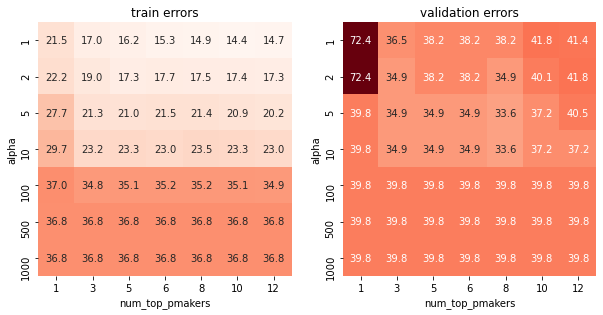

In [221]:
# Trực quan hóa kết quả
train_errs_df = pd.DataFrame(data=np.array(train_errs).reshape(len(alphas), -1),
                             index=alphas, columns=num_top_pmakers_s)
val_errs_df = pd.DataFrame(data=np.array(val_errs).reshape(len(alphas), -1), 
                           index=alphas, columns=num_top_pmakers_s)
min_err = min(min(train_errs), min(val_errs))
max_err = max(max(train_errs), max(val_errs))
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.heatmap(train_errs_df, vmin=min_err, vmax=max_err, square=True, annot=True, 
            cbar=False, fmt='.1f', cmap='Reds')
plt.title('train errors'); plt.xlabel('num_top_pmakers'); plt.ylabel('alpha')
plt.subplot(1, 2, 2)
sns.heatmap(val_errs_df, vmin=min_err, vmax=max_err, square=True, annot=True, 
            cbar=False, fmt='.1f', cmap='Reds')
plt.title('validation errors'); plt.xlabel('num_top_pmakers'); plt.ylabel('alpha');

- Biểu đồ lỗi của hai tập tr_X và val_X

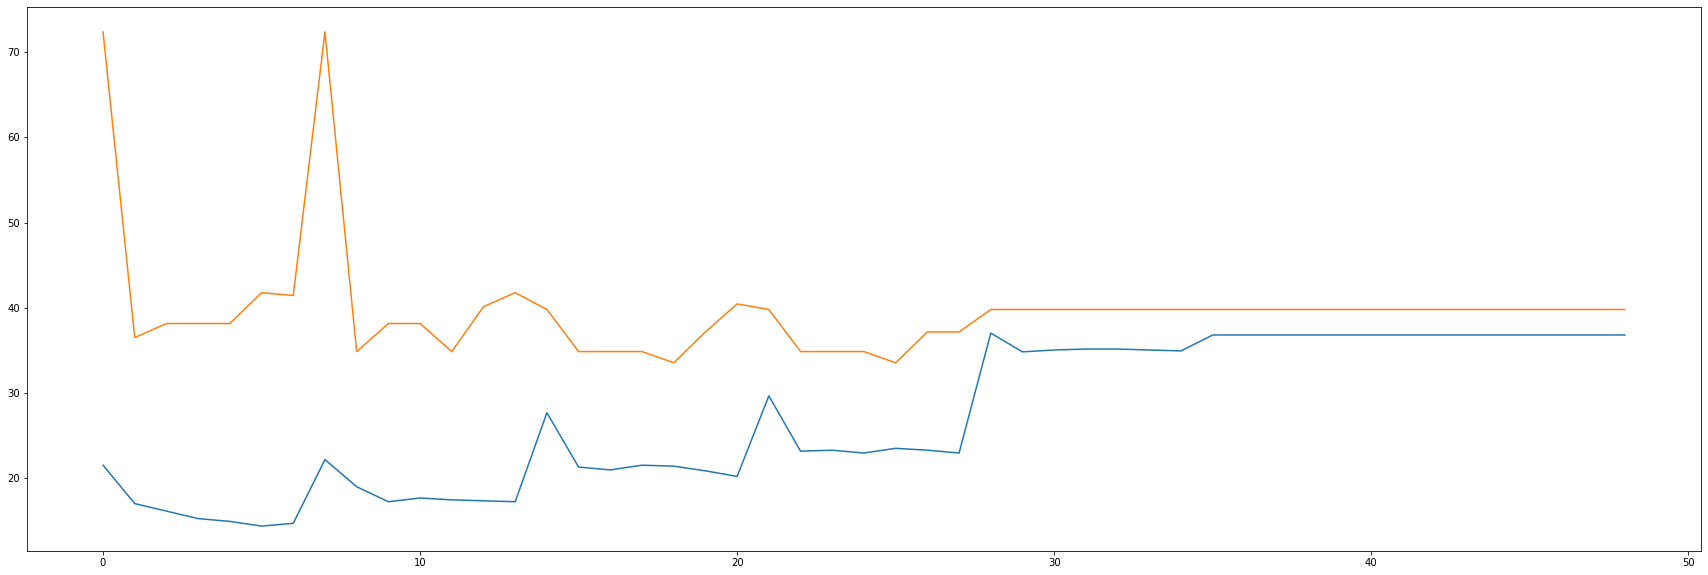

In [231]:
plt.figure(figsize=(30,10))

plt.plot(train_errs)

plt.plot(val_errs)
plt.show()

- Mô hình hóa tập dữ liệu train với các giá trị best_alpha và best_num_top_pmakers nhận được từ trên:

In [200]:
full_pipeline_mlpclassifier.set_params(pipeline__coladderdropper__num_top_pmakers=best_num_top_pmakers,mlpclassifier__alpha = best_alpha)
m_mlpclassifier=full_pipeline_mlpclassifier.fit(train_X,train_y)

In [222]:
# Độ lỗi của mô hình dự đoán trên tập test.
print('Test error: ', (1- m_mlpclassifier.score(test_X,test_y))*100)

Test error:  37.82894736842105


- Nhận xét: Tỉ lệ dự đoán điện thoại ở mức giá rẻ ở lớp dự đoán cao hơn nhiều so với ban đầu

In [223]:
# Dự đoán trên tập test:
test_err = (1 -  m_mlpclassifier.score(test_X,test_y))*100
print('Test error: ', test_err,'%')

Test error:  37.82894736842105 %


### Dự đoán mức giá bằng mô hình LogisticRegression
- Tạo pipeline có tên là: full_pipeline_logisticregression để tiến hành tiền xử lí và mô hình hóa.

In [224]:
full_pipeline_logisticregression = make_pipeline(
    (preprocess_pipeline),
    (LogisticRegression(multi_class='multinomial',random_state =0)))

- Mô hình hóa với tập train

In [225]:
m_logisticregression=full_pipeline_logisticregression.fit(train_X,train_y)

In [226]:
# Tính độ lỗi trên tập Train.
print('Train error: ',(1-m_logisticregression.score(train_X,train_y))*100,' %')

Train error:  29.077429983525537  %


In [227]:
# Tính độ lỗi trên tập test
print('Test error: ',(1-m_logisticregression.score(test_X,test_y))*100,' %')

Test error:  37.82894736842105  %


# Tổng kết:

#### Khó khăn: 
- Dữ liệu thu thập từ các trang web bán hàng ở Việt Nam nên dữ định dạng dữ liệu ở mỗi trang mỗi khác nhau, khó khăn trong quá trình xử lí.
- Chưa thành thạo Visualize nên phải thao khảo nhiều từ ví dụ của thầy.

#### Nội dung học được từ việc làm đồ án:
- Nắm được nhiều kiến thức hơn về github, jupyter notebook, hiểu hơn các mô hình neural network

#### Cải tiến đồ án:
- Thu thập nhiều dữ liệu hơn để dự đoán giá sản phẩm, chứ không chỉ dừng ở việc phân loại mức giá cho sản phẩm.

### Tham khảo:
1. MPLClassifier: https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html 

2. LogistcRegression: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

3. Trực quan hóa dữ liệu và tiền xử lí dữ liệu: File bài tập 3 : Tiền xử lí và mô hình hóa.